## <font color="white">Library Imports</font>

In [25]:
import pandas as pd
import math
import matplotlib.pyplot as plt

## <font color="white">Basic EDA</font>

In [24]:
train = pd.read_parquet("drw-data/train.parquet")
print(train.head())
 

# Just a rundown of what the label means:

# The columns at the top (e.g., bid_qty, ask_qty, and X1 through X890) are all features — variables that DRW may have used 
# in their internal algorithm to calculate the "label" for each timestamp.

# The label represents the future price movement after that specific minute — think of it as how much the price changed 
# shortly after the current timestamp (likely over the next 1 minute, though the exact formula is unknown). 

# Our task is to use machine learning or other modeling techniques to approximate that hidden formula — 
# figuring out which features are most useful and how they relate to the label, in order to predict it as accurately as possible.


                     bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
timestamp                                                                     
2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.121263   
2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.302841   
2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.167462   
2023-03-01 00:03:00    4.865   21.016  335.742   124.963  460.705  0.072944   
2023-03-01 00:04:00   27.158    3.451   98.411    44.407  142.818  0.173820   

                           X2        X3        X4        X5  ...      X882  \
timestamp                                                    ...             
2023-03-01 00:00:00 -0.417690  0.005399  0.125948  0.058359  ...  1.925423   
2023-03-01 00:01:00 -0.049576  0.356667  0.481087  0.237954  ...  1.928569   
2023-03-01 00:02:00 -0.291212  0.083138  0.206881  0.101727  ...  1.928047   
2023-03-01 00:03:00 -0.436590 -0.102483  0.017551  0.007

## Label Testing

Label summary:
 count    525887.000000
mean          0.036126
std           1.009914
min         -24.416615
25%          -0.381585
50%           0.016262
75%           0.434135
max          20.740270
Name: label, dtype: float64


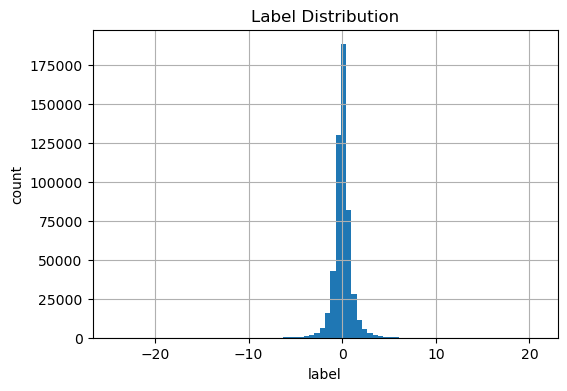

In [29]:
print("Label summary:\n", train["label"].describe())

plt.figure(figsize=(6,4))
train["label"].hist(bins=80)
plt.title("Label Distribution")
plt.xlabel("label")
plt.ylabel("count")
plt.show()

# Normally distributed?

## Public Features Testing


array([[<Axes: title={'center': 'bid_qty'}>,
        <Axes: title={'center': 'ask_qty'}>],
       [<Axes: title={'center': 'buy_qty'}>,
        <Axes: title={'center': 'sell_qty'}>],
       [<Axes: title={'center': 'volume'}>, <Axes: >]], dtype=object)

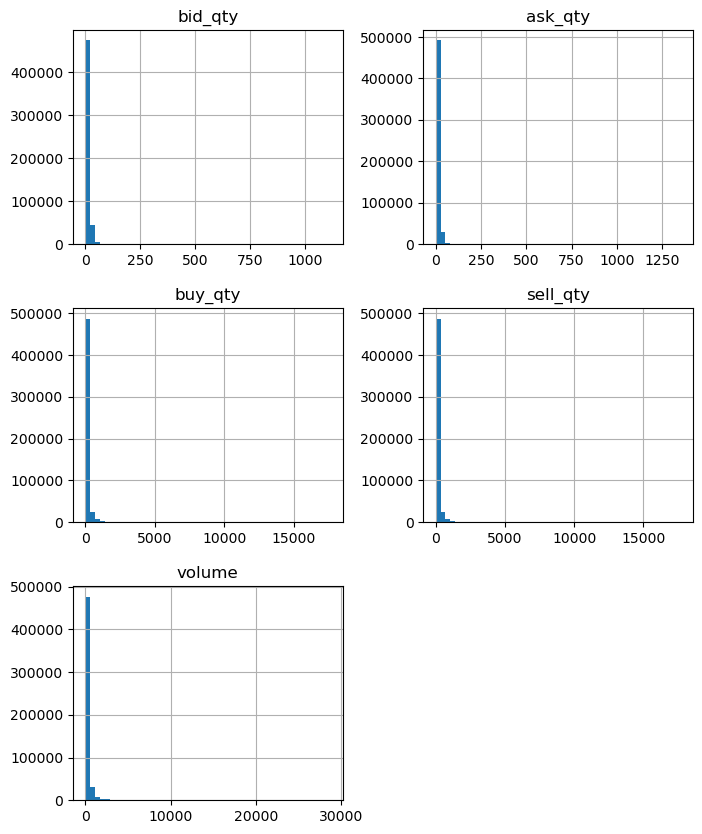

In [41]:
public = ["bid_qty","ask_qty","buy_qty","sell_qty","volume"]
train[public].describe()
train[public].hist(bins=50, figsize=(8,10))

# x-axis represents the 

Public feature ↔ Label correlations:
  bid_qty  : -0.0132
  ask_qty  : -0.0158
  buy_qty  : 0.0056
  sell_qty : 0.0112
  volume   : 0.0088
------------------------------------
Imbalance & Label Correlation
count    525887.000000
mean         -0.006292
std           0.632425
min          -0.999973
25%          -0.576921
50%          -0.017002
75%           0.566869
max           0.999970
Name: imbalance, dtype: float64
Imbalance ↔ Label correlation: 0.0110


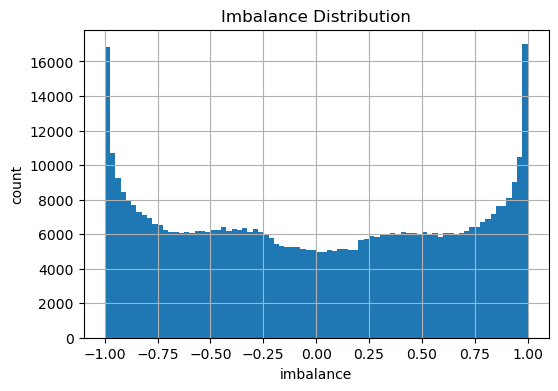

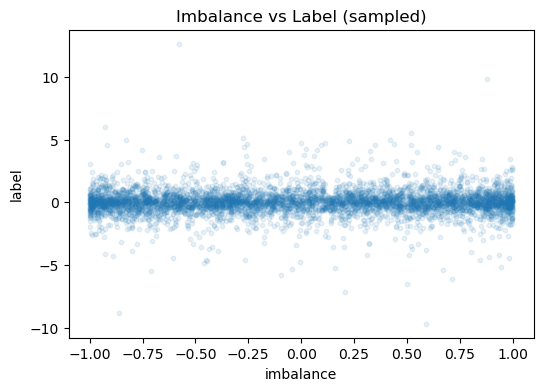

In [52]:
# Compute Pearson correlation of each public feature with the label
public = ["bid_qty","ask_qty","buy_qty","sell_qty","volume"]
corrs = {}

for pubFeat in public:
    corrs[pubFeat] = train[pubFeat].corr(train["label"])


print("Public feature ↔ Label correlations:")
for feat, val in corrs.items():
    print(f"  {feat:8s} : {val:.4f}")

# Results are pretty insignificant. QTY of stuff doesn't make much impact. 
# Maybe look at imbalance between buyers and sellers (bid > ask??)


print("------------------------------------")
print("Imbalance & Label Correlation")
# 1) Engineer the imbalance feature correctly
train["imbalance"] = (
    train["bid_qty"] - train["ask_qty"]
) / (
    train["bid_qty"] + train["ask_qty"]
)

# Summary
print(train["imbalance"].describe())

# Pearson Correlation
corr_imb = train["imbalance"].corr(train["label"])
print(f"Imbalance ↔ Label correlation: {corr_imb:.4f}")


plt.figure(figsize=(6,4))
train["imbalance"].hist(bins=80)
plt.title("Imbalance Distribution")
plt.xlabel("imbalance")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(6,4))
idx = train.sample(5000, random_state=1).index
plt.scatter(train.loc[idx, "imbalance"], train.loc[idx, "label"],
            alpha=0.1, s=10)
plt.title("Imbalance vs Label (sampled)")
plt.xlabel("imbalance")
plt.ylabel("label")
plt.show()

#yea nvm we don't have jack shit w public features


## Private Features Testing

In [63]:
sample = train.sample(100000, random_state=40)

PrivFeatures = [f"X{i}" for i in range(1, 101)]

corrs_x = {} # dict
for feat in PrivFeatures:
    a = sample[feat]
    b = sample["label"]
    pearsonCoefficient = a.corr(b, method="pearson")
    corrs_x[feat] = abs(pearsonCoefficient)

# Feat -> Coefficient Dict
# sorted(iterable, key = how to sort, sort order)
top_10_feat = sorted(corrs_x.items(), key=lambda x: x[1], reverse=True) 

print("Top 10 X-features by |corr| with label:")
for feat, val in top10:
    print(f"  {feat:5s} → {val:.4f}")


Top 10 X-features by |corr| with label:
  X21   → 0.0761
  X20   → 0.0742
  X19   → 0.0680
  X28   → 0.0679
  X27   → 0.0668
  X29   → 0.0655
  X22   → 0.0635
  X26   → 0.0569
  X18   → 0.0532
  X30   → 0.0521
